In [212]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess as sp
import time
import multiprocessing as mp
colors = "rgbcmykw"

# Problem 1

### First a sanity check to see if we generate graphs with $\left<k\right> = 10$

In [58]:
getVals = lambda x: list(dict(x).values())
getKeys = lambda x: list(dict(x).keys())

meanK = 10

G1 = nx.generators.erdos_renyi_graph(1000, meanK / 999)
G2 = nx.generators.watts_strogatz_graph(1000, 10, 0.1)
G3 = nx.generators.watts_strogatz_graph(1000, 10, 0.01)
G4 = nx.generators.barabasi_albert_graph(1000, 5)

[ np.mean(list(dict(G.degree).values())) for G in (G1, G2, G3, G4)]

[9.724, 10.0, 10.0, 9.95]

In [59]:
results = {
    "generator": [],
    "numNodes": [],
    "avgDeg": [],
    "2moment": [],
    "avgShortestPath": [],
    "avgClusterCoeff": [],
    "transitivity": [],
    "assortativity": []
}

def addResult(G, generator):
    results["generator"].append(generator)
    results["numNodes"].append(len(G.nodes))
    
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    moment1 = np.sum([ x*p      for x, p in zip(histX, histY) ])
    moment2 = np.sum([ (x**2)*p for x, p in zip(histX, histY) ])
    results["avgDeg"].append(moment1)
    results["2moment"].append(moment2)
    
    component = max(nx.components.connected_component_subgraphs(G), key=len)
    results["avgShortestPath"].append(nx.average_shortest_path_length(component))
    
    results["avgClusterCoeff"].append(nx.average_clustering(G))
    results["transitivity"].append(nx.transitivity(G))
    results["assortativity"].append(nx.assortativity.degree_assortativity_coefficient(G))

for i in range(30):
    print(i, end=" ")
    G1 = nx.generators.erdos_renyi_graph(1000, meanK / 999, seed=72+i)
    G2 = nx.generators.watts_strogatz_graph(1000, 10, 0.1, seed=72+i)
    G3 = nx.generators.watts_strogatz_graph(1000, 10, 0.01, seed=72+i)
    G4 = nx.generators.barabasi_albert_graph(1000, 5, seed=72+i)
    
    addResult(G1, "Erdos")
    addResult(G2, "Watts0.1")
    addResult(G3, "Watts0.01")
    addResult(G4, "Barabasi")

df = pd.DataFrame(results)
df

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

,generator,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
0,Erdos,1000,10.048,111.172,3.250414,0.010642,0.010621,-0.008713
1,Watts0.1,1000,10.000,100.858,4.525021,0.507541,0.498448,-0.010800
2,Watts0.01,1000,10.000,100.070,10.656440,0.653831,0.652959,-0.000707
3,Barabasi,1000,9.950,198.688,2.996623,0.037308,0.029597,-0.042608
4,Erdos,1000,9.884,107.356,3.270376,0.011277,0.010772,-0.002362
...,...,...,...,...,...,...,...,...
115,Barabasi,1000,9.950,212.056,2.968631,0.042497,0.030608,-0.061973
116,Erdos,1000,9.896,106.808,3.270501,0.008673,0.008544,0.018046
117,Watts0.1,1000,10.000,100.932,4.452855,0.496982,0.488145,-0.004748
118,Watts0.01,1000,10.000,100.068,10.681618,0.653909,0.653107,-0.006745


In [60]:
groups = df.groupby(by="generator")
mean = groups.mean()
std = groups.std()

### Mean:

In [61]:
mean

,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
generator,,,,,,,
Barabasi,1000,9.950000,203.395867,2.980822,0.039911,0.029691,-0.058270
Erdos,1000,10.003867,109.985200,3.255601,0.010142,0.010088,-0.002255
Watts0.01,1000,10.000000,100.097600,9.052121,0.648064,0.646797,0.002152
Watts0.1,1000,10.000000,100.938533,4.445761,0.492419,0.483567,-0.010739


### Standard Deviation

In [62]:
std

,numNodes,avgDeg,2moment,avgShortestPath,avgClusterCoeff,transitivity,assortativity
generator,,,,,,,
Barabasi,0.0,1.277547e-15,6.020609,0.013834,0.003039,0.001184,0.009194
Erdos,0.0,1.289843e-01,2.733284,0.016547,0.000981,0.000935,0.012675
Watts0.01,0.0,1.189331e-15,0.017922,0.842908,0.003425,0.003650,0.010803
Watts0.1,0.0,1.277547e-15,0.053914,0.050624,0.007857,0.008176,0.016257


Degree distributions. Each row is:
1 - Erdos Renyi
2 - Watts-Strogatz p=0.01
3 - Watts-Strogatz p=0.1
4 - Barabasi-Albert



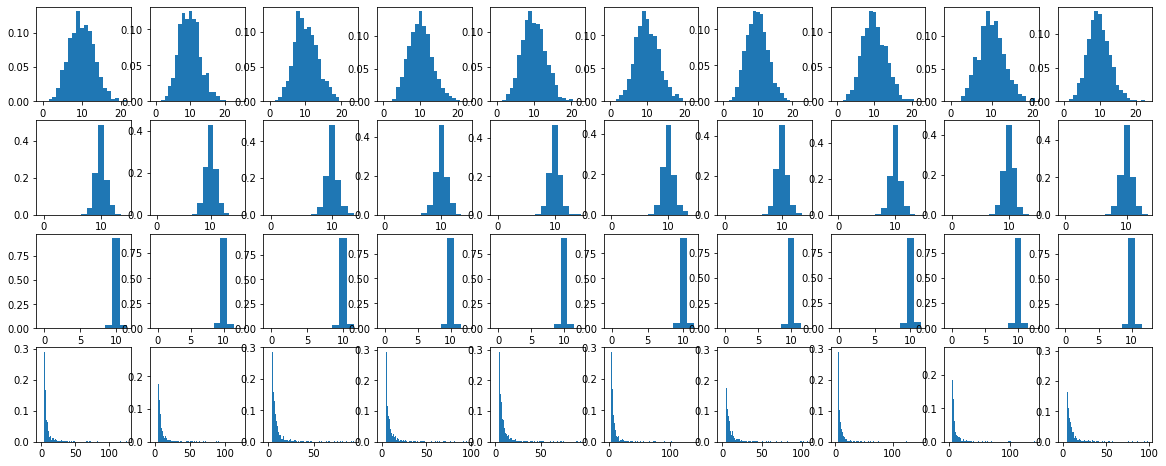

In [243]:
fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(20, 8))

print("""Degree distributions. Each row is:
1 - Erdos Renyi
2 - Watts-Strogatz p=0.01
3 - Watts-Strogatz p=0.1
4 - Barabasi-Albert
""")

for i in range(10):
    G = nx.generators.erdos_renyi_graph(1000, meanK / 1000, seed=72+i)
    degs = getVals(G.degree)
    ax[0, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)
    
for i in range(10):
    G = nx.generators.watts_strogatz_graph(1000, 10, 0.1, seed=72+i)
    degs = getVals(G.degree)
    ax[1, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

for i in range(10):
    G = nx.generators.watts_strogatz_graph(1000, 10, 0.01, seed=72+i)
    degs = getVals(G.degree)
    ax[2, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

for i in range(10):
    G = nx.generators.barabasi_albert_graph(1000, 5, seed=72+i)
    degs = getVals(G.degree)
    ax[3, i].hist(degs, bins=np.arange(-1, max(degs)+1) + 0.5, density=True)

### We see that Erdos-Renyi and Watts-Strogatz have degree distributions of similar shape, and they are not scale free. Barabasi-Albert is the only scale-free model here.

### We see high clustering coefficients and transitivity in both Watts-Strogatz models, so there must be a large number of triangles in such a graph. Despite this, the average shortest paths here were larger than I expected: the network is highly clustered, but the average distance is still quite high. 

### A larger second moment for the Barabasi graph is observed. This reflects the larger variance in scale-free graphs. On the other hand, the second moments for both the Watts graphs are very similar (the variance would be almost 0); I expected them to be different and larger.

### Finally, all model showed assortativity near 0, reflecting their random nature. If we wanted the assortativity to be within a specific range, we would need to employ a model specific for this purpose.

# Problem 2

Text(0, 0.5, 'Nodes in Giant Component')

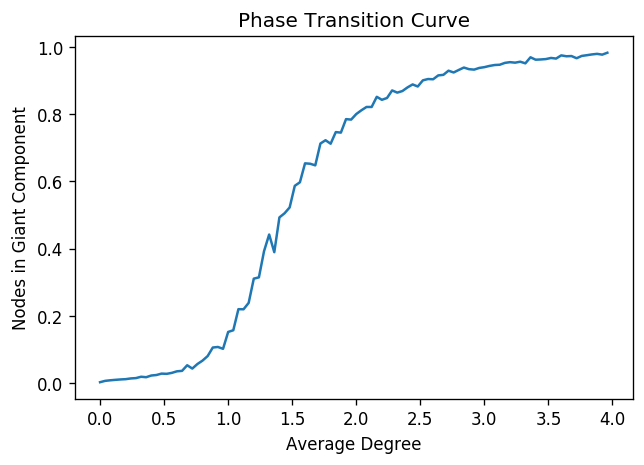

In [298]:
y = []
x = np.arange(0, 4, step=4/100)

NNODES = 300

for avgDeg in x:
    aux = []
    for i in range(20):
        giantComp = max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(NNODES, avgDeg / (NNODES-1))), key=len)
        aux.append(len(giantComp.nodes) / NNODES)
    y.append(np.mean(aux))

plt.figure(dpi=120)
plt.plot(x, y)
plt.title("Phase Transition Curve")
plt.xlabel("Average Degree")
plt.ylabel("Nodes in Giant Component")

(4,100) (4,200) (4,300) (4,400) (4,500) (4,600) (4,700) (4,800) (4,900) (4,1000) (10,100) (10,200) (10,300) (10,400) (10,500) (10,600) (10,700) (10,800) (10,900) (10,1000) (20,100) (20,200) (20,300) (20,400) (20,500) (20,600) (20,700) (20,800) (20,900) (20,1000) (30,100) (30,200) (30,300) (30,400) (30,500) (30,600) (30,700) (30,800) (30,900) (30,1000) 

Text(0.5, 0, 'dMax')

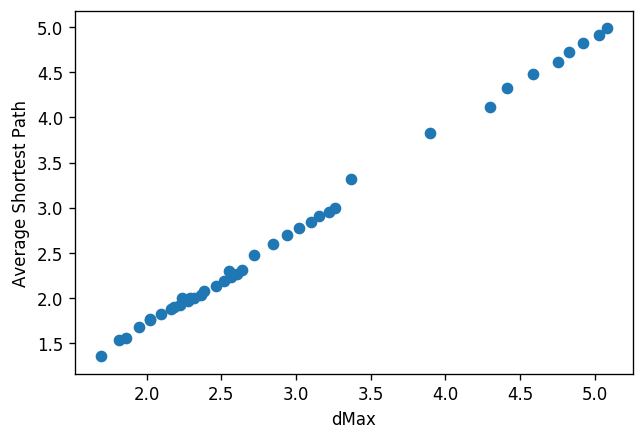

In [313]:
avgShortestPath = []
dMax = []

for avgDeg in (4, 10, 20, 30):
    for N in np.arange(100, 1001, step=100):
        print("({},{})".format(avgDeg, N), end=" ")
        avgSP = 0
        dM = 0
        nIter = 10

        for i in range(nIter):
            giantComp = max(nx.connected_component_subgraphs(nx.erdos_renyi_graph(N, avgDeg / (N-1))), key=len)
            avgSP += nx.average_shortest_path_length(giantComp)
            dM += np.log(N) / np.log(avgDeg)

        avgShortestPath.append(avgSP / nIter)
        dMax.append(dM / nIter)

plt.figure(dpi=120)
plt.scatter(avgShortestPath, dMax, cmap="rainbow")
plt.ylabel("Average Shortest Path")
plt.xlabel("dMax")

### The points lie on the line $y = x$, which characterizes small-world networks (though this did not work for average degrees lower than 4 when I tried earlier).

# Problem 3

In [65]:
p = np.concatenate([
#    np.linspace(1e-4, 1e-3, num=10),
    np.linspace(1e-3, 1e-2, num=10),
    np.linspace(1e-2, 1e-1, num=10),
    np.linspace(1e-1, 1e-0, num=10)
])
    
avgPath = []
clustering = []

maxG = nx.watts_strogatz_graph(100, 10, 0)
maxAvgPath = nx.average_shortest_path_length(maxG)
maxClustering = nx.average_clustering(maxG)

for pi in p:
    print(np.round(pi, decimals=1), end=" ")
    
    graph = lambda p: nx.watts_strogatz_graph(100, 10, p)
    path  = lambda G: nx.average_shortest_path_length(G)
    clus  = lambda G: nx.average_clustering(G)
    
    avgPath.append(np.mean([path(graph(pi)) for i in range(10) ]) / maxAvgPath)
    clustering.append(np.mean([ clus(graph(pi)) for i in range(10) ]) / maxClustering)

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 

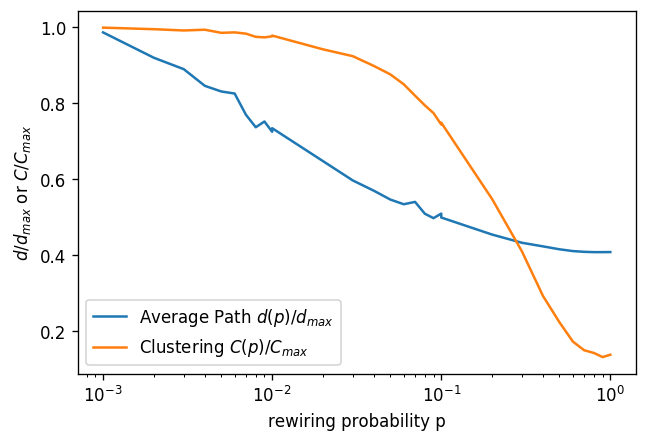

In [66]:
plt.figure(dpi=120)
plt.plot(p, avgPath, label="Average Path $d(p) /d_{max}$")
plt.plot(p, clustering, label="Clustering $C(p) / C_{max}$")
plt.xscale("log")
plt.xlabel("rewiring probability p")
plt.ylabel("$d/d_{max}$ or $C/C_{max}$")
plt.legend()

In [69]:
p = np.linspace(0, 1, num=100)
y = [] # second moment

for pi in p:
    print(np.round(pi, decimals=1), end=" ")

    graph = lambda p: nx.watts_strogatz_graph(100, 10, p)
    def var(G):
        degs = np.array(getVals(G.degree))
        histX = np.arange(0, np.max(degs) + 1)
        histY = [ np.sum(degs == i) for i in histX ]
        histY = histY / np.sum(histY) # normalize
        mean = np.sum([ x*p for x, p in zip(histX, histY) ])
        return np.sum([ (x**2)*p for x, p in zip(histX, histY) ]) - mean**2

    y.append(np.mean([var(graph(pi)) for i in range(10) ]) / maxAvgPath)

0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 1.0 1.0 1.0 1.0 1.0 

Text(0.5, 0, 'rewiring probability p')

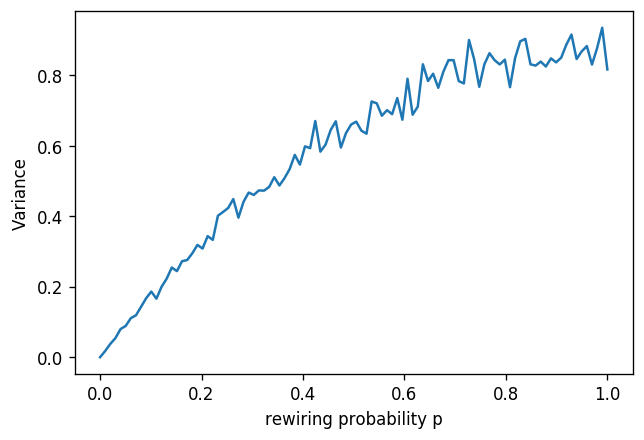

In [71]:
plt.figure(dpi=120)
plt.plot(p, y)
plt.ylabel("Variance")
plt.xlabel("rewiring probability p")

### We see that the variance of the degree distribution increased with $p$, as expected. Without any rewiring, the degrees are all the same, so variance is 0. The variance should increase as we increase the number of rewirings.

Text(0, 0.5, 'Probability')

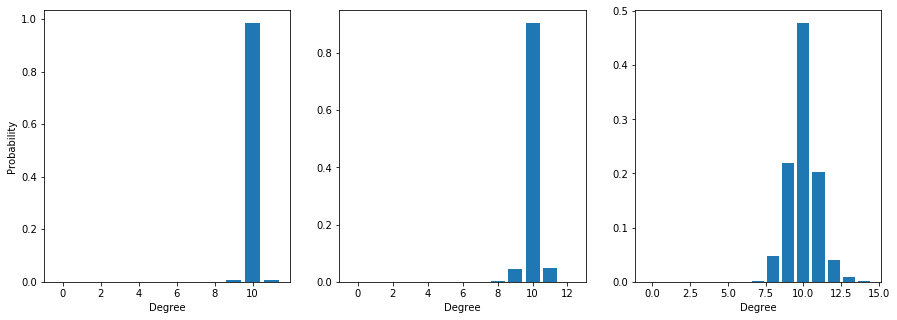

In [78]:
p = [0.001, 0.01, 0.1]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax = np.ravel(ax)

for idx, pi in enumerate(p):
    G = nx.watts_strogatz_graph(1000, 10, pi)

    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    ax[idx].bar(histX, histY)
    ax[idx].set_xlabel("Degree")
ax[0].set_ylabel("Probability")

0 0.001 0.01 0.1 1 

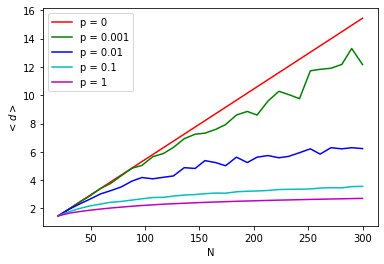

In [101]:
allN = np.int32(np.round(np.linspace(20, 300, num=30)))
colors = "rgbcmykw"

for idx, p in enumerate([0, 0.001, 0.01, 0.1, 1]):
    print(p, end=" ")
    y = []
    for N in allN:
        graph = lambda N, p: nx.watts_strogatz_graph(N, 10, p)
        path  = lambda G: nx.average_shortest_path_length(G)
        y.append(np.mean([path(graph(N, p)) for i in range(10) ]))
    plt.plot(allN, y, c=colors[idx], label="p = {}".format(p))

plt.xlabel("N")
plt.ylabel("$<d>$")
plt.legend()

### We see that the average shortest path tends to become shorter as we increase $p$. Of course this was expected, as the graph with $p = 0$ forms a very regular structure. Each node is only connected to its immediate neighbors in a circular structure; when we rewire the edges, we introduce shortcuts.

# Problem 4

In [130]:
#z = nx.utils.create_degree_sequence(100, nx.utils.powerlaw_sequence)
#G = nx.configuration_model(z)
#G

results = {
    "generator": [],
    "numNodes": [],
    "avgDeg": [],
    "2moment": [],
    "avgShortestPath": [],
    "avgClusterCoeff": [],
    "transitivity": [],
    "assortativity": []
}

def addResult(G, generator):
    results["generator"].append(generator)
    results["numNodes"].append(len(G.nodes))
    
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    moment1 = np.sum([ x*p      for x, p in zip(histX, histY) ])
    moment2 = np.sum([ (x**2)*p for x, p in zip(histX, histY) ])
    results["avgDeg"].append(moment1)
    results["2moment"].append(moment2)
    
    component = max(nx.components.connected_component_subgraphs(G), key=len)
    results["avgShortestPath"].append(nx.average_shortest_path_length(component))
    
    results["avgClusterCoeff"].append(nx.average_clustering(G))
    results["transitivity"].append(nx.transitivity(G))
    results["assortativity"].append(nx.assortativity.degree_assortativity_coefficient(G))

for N in [100, 300, 1000]:
    for i in range(30):
        print("{}-{}".format(N, i), end=" ")
        G = nx.barabasi_albert_graph(N, 5)
        addResult(G, "barabasi")
                
        seq = sorted(np.int32(np.round(nx.utils.powerlaw_sequence(N, 3))))
        
        if np.sum(seq)%2 == 1:
            seq[-1] += 1
        
        G = nx.Graph(nx.configuration_model(seq))
        addResult(G, "configuration")

df = pd.DataFrame(results)

100-0 100-1 100-2 100-3 100-4 100-5 100-6 100-7 100-8 100-9 100-10 100-11 100-12 100-13 100-14 100-15 100-16 100-17 100-18 100-19 100-20 100-21 100-22 100-23 100-24 100-25 100-26 100-27 100-28 100-29 300-0 300-1 300-2 300-3 300-4 300-5 300-6 300-7 300-8 300-9 300-10 300-11 300-12 300-13 300-14 300-15 300-16 300-17 300-18 300-19 300-20 300-21 300-22 300-23 300-24 300-25 300-26 300-27 300-28 300-29 1000-0 1000-1 1000-2 1000-3 1000-4 1000-5 1000-6 1000-7 1000-8 1000-9 1000-10 1000-11 1000-12 1000-13 1000-14 1000-15 1000-16 1000-17 1000-18 1000-19 1000-20 1000-21 1000-22 1000-23 1000-24 1000-25 1000-26 1000-27 1000-28 1000-29 

In [131]:
groups = df.groupby(by=["generator", "numNodes"])
groups.mean()

avgDeg     2moment  avgShortestPath  \
generator     numNodes                                          
barabasi      100       9.500000  132.402667         2.220916   
              300       9.833333  168.681778         2.605168   
              1000      9.950000  206.111267         2.975145   
configuration 100       1.910000    7.758000         4.751074   
              300       1.916667   11.028889         6.250994   
              1000      1.920533    9.965933         7.105755   

                        avgClusterCoeff  transitivity  assortativity  
generator     numNodes                                                
barabasi      100              0.193194      0.158105      -0.113462  
              300              0.095210      0.073712      -0.082348  
              1000             0.040654      0.030154      -0.057335  
configuration 100              0.019517      0.027512      -0.056049  
              300              0.010149      0.010109      -0.052820  
              1000             0.003717      0.005017      -0.020882

### Contrary to expectations, the two models are very different. Only the assortativity is similar. Let us plot their degree distributions to try to understand this

Text(0.5, 1.0, 'Configuration Model')

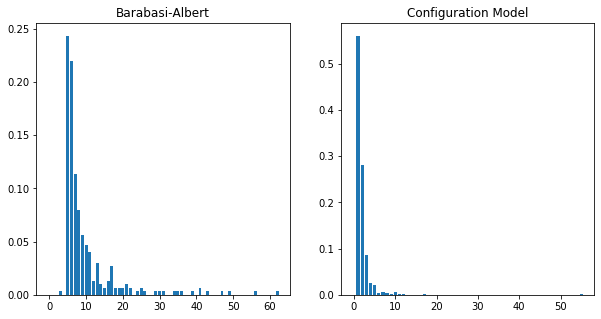

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax = ax.ravel()

G = nx.barabasi_albert_graph(300, 5)
degs = np.array(getVals(G.degree))
histX = np.arange(0, np.max(degs) + 1)
histY = [ np.sum(degs == i) for i in histX ]
histY = histY / np.sum(histY) # normalize

ax[0].bar(histX, histY)
ax[0].set_title("Barabasi-Albert")

seq = sorted(np.int32(np.round(nx.utils.powerlaw_sequence(N, 3))))
if np.sum(seq)%2 == 1:
    seq[-1] += 1
G = nx.Graph(nx.configuration_model(seq))
degs = np.array(getVals(G.degree))
histX = np.arange(0, np.max(degs) + 1)
histY = [ np.sum(degs == i) for i in histX ]
histY = histY / np.sum(histY) # normalize

ax[1].bar(histX, histY)
ax[1].set_title("Configuration Model")

### It seems that the value of $m=5$ makes the Barabasi model be too different from the configuration model. Let's try with other values of $m$

(0, 40)

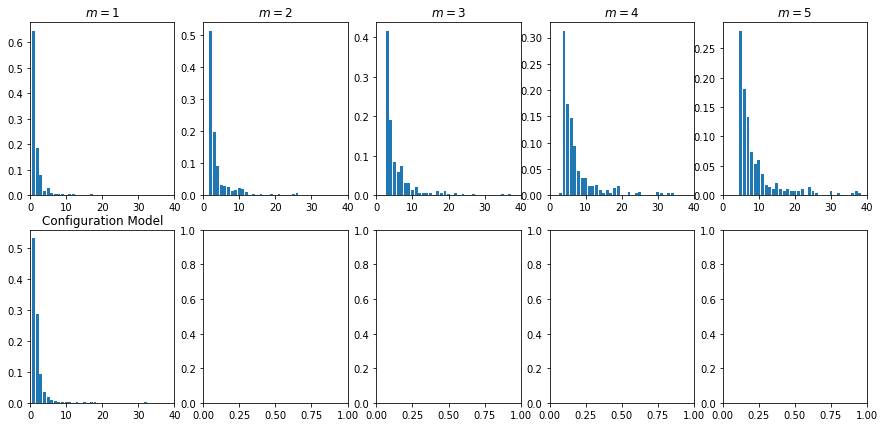

In [145]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,7))

ax = ax.ravel()

for idx, m in enumerate([1, 2, 3, 4, 5]):
    G = nx.barabasi_albert_graph(300, m)
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize

    ax[idx].bar(histX, histY)
    ax[idx].set_title("$m = {}$".format(m))
    ax[idx].set_xlim([0, 40])

seq = sorted(np.int32(np.round(nx.utils.powerlaw_sequence(N, 3))))
if np.sum(seq)%2 == 1:
    seq[-1] += 1
G = nx.Graph(nx.configuration_model(seq))
degs = np.array(getVals(G.degree))
histX = np.arange(0, np.max(degs) + 1)
histY = [ np.sum(degs == i) for i in histX ]
histY = histY / np.sum(histY) # normalize

ax[5].bar(histX, histY)
ax[5].set_title("Configuration Model")
ax[5].set_xlim([0, 40])

### Apparently, $m = 1$ is the most suitable... Let us repeat the previous experiments then

In [146]:
#z = nx.utils.create_degree_sequence(100, nx.utils.powerlaw_sequence)
#G = nx.configuration_model(z)
#G

results = {
    "generator": [],
    "numNodes": [],
    "avgDeg": [],
    "2moment": [],
    "avgShortestPath": [],
    "avgClusterCoeff": [],
    "transitivity": [],
    "assortativity": []
}

def addResult(G, generator):
    results["generator"].append(generator)
    results["numNodes"].append(len(G.nodes))
    
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    moment1 = np.sum([ x*p      for x, p in zip(histX, histY) ])
    moment2 = np.sum([ (x**2)*p for x, p in zip(histX, histY) ])
    results["avgDeg"].append(moment1)
    results["2moment"].append(moment2)
    
    component = max(nx.components.connected_component_subgraphs(G), key=len)
    results["avgShortestPath"].append(nx.average_shortest_path_length(component))
    
    results["avgClusterCoeff"].append(nx.average_clustering(G))
    results["transitivity"].append(nx.transitivity(G))
    results["assortativity"].append(nx.assortativity.degree_assortativity_coefficient(G))

for N in [100, 300, 1000]:
    for i in range(30):
        print("{}-{}".format(N, i), end=" ")
        G = nx.barabasi_albert_graph(N, 1)
        addResult(G, "barabasi")
                
        seq = sorted(np.int32(np.round(nx.utils.powerlaw_sequence(N, 3))))
        
        if np.sum(seq)%2 == 1:
            seq[-1] += 1
        
        G = nx.Graph(nx.configuration_model(seq))
        addResult(G, "configuration")

df = pd.DataFrame(results)

100-0 100-1 100-2 100-3 100-4 100-5 100-6 100-7 100-8 100-9 100-10 100-11 100-12 100-13 100-14 100-15 100-16 100-17 100-18 100-19 100-20 100-21 100-22 100-23 100-24 100-25 100-26 100-27 100-28 100-29 300-0 300-1 300-2 300-3 300-4 300-5 300-6 300-7 300-8 300-9 300-10 300-11 300-12 300-13 300-14 300-15 300-16 300-17 300-18 300-19 300-20 300-21 300-22 300-23 300-24 300-25 300-26 300-27 300-28 300-29 1000-0 1000-1 1000-2 1000-3 1000-4 1000-5 1000-6 1000-7 1000-8 1000-9 1000-10 1000-11 1000-12 1000-13 1000-14 1000-15 1000-16 1000-17 1000-18 1000-19 1000-20 1000-21 1000-22 1000-23 1000-24 1000-25 1000-26 1000-27 1000-28 1000-29 

In [147]:
groups = df.groupby(["generator", "numNodes"])
groups.mean()

avgDeg    2moment  avgShortestPath  avgClusterCoeff  \
generator     numNodes                                                          
barabasi      100       1.980000  10.708667         4.629751         0.000000   
              300       1.993333  12.625556         5.766653         0.000000   
              1000      1.998000  14.936133         6.932452         0.000000   
configuration 100       1.874667   6.969333         5.124916         0.013296   
              300       1.924000  13.841111         6.185076         0.012302   
              1000      1.957867  12.051133         6.726386         0.004853   

                        transitivity  assortativity  
generator     numNodes                               
barabasi      100           0.000000      -0.251758  
              300           0.000000      -0.184857  
              1000          0.000000      -0.121528  
configuration 100           0.020502      -0.053293  
              300           0.011108      -0.066410  
              1000          0.006011      -0.033868

### This makes much more sense, although the average clustering and the transitivity being 0 is really weird (we will investigate this below)

### The other metrics are very similar among the models, especially for $N = 1000$. For $N < 1000$ we have that the degree variance is lower in the Configuration model. Shortest paths are about the same for both models.

Clustering: 0.0


/home/mathjs/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


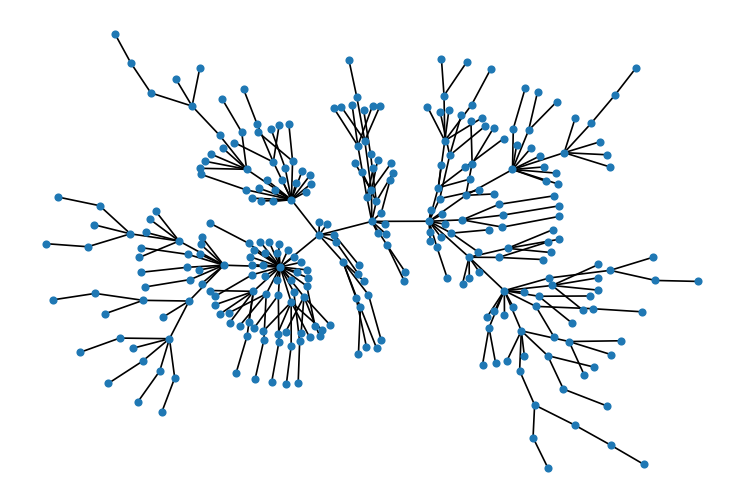

In [154]:
plt.figure(dpi=120)
G = nx.barabasi_albert_graph(300, 1)
print("Clustering:", nx.average_clustering(G))
nx.draw_kamada_kawai(G, with_labels=False, node_size=15)

### It does seem that there are no triangles in this graph (is this a tree graph?). The barabasi works by adding nodes iteratively, and node $n_i$ connects to $m$ nodes $n_j, j < i$; it seems that we would need the new node to connect to 2 other nodes in order to form a triangle. Therefore we end up with a tree graph, and thus the clustering coefficient is 0, and the transitivity is also 0.

266

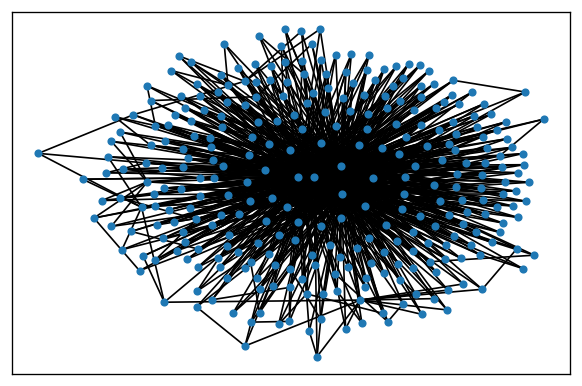

In [192]:
def graph(N, m, power):
    output = sp.check_output("./nonlinear_barabasi {} {} {}".format(N, m, power)\
               .split(" "))\
               .decode("utf8")
    output = output.split("\n")[:-1]
    output = [ i.split(" ") for i in output ]
    output = np.array(output, dtype=np.int32)
    return nx.from_edgelist(output)

plt.figure(dpi=120)
G = graph(300, 3, 1.5)
nx.draw_networkx(G, with_labels=False, node_size=15)
max(getVals(G.degree))

In [227]:
colors = "rgb"
allT = np.int32(np.round(np.logspace(1, 5, num=40)))

beg = time.time()

def function(alpha):
    allY = []
    for t in allT:
        G = graph(t, 3, alpha)
        allY.append(max(getVals(G.degree)))
    return allY

with mp.Pool(4) as p:
    result = p.map(function, [0.5, 1, 2.5])

end = time.time() - beg
print("Elapsed:", end / 60 / 60, "hours")
result

Elapsed: 0.0668892674975925 hours


[[8,
  9,
  9,
  12,
  13,
  14,
  15,
  20,
  27,
  30,
  30,
  25,
  27,
  36,
  38,
  46,
  37,
  50,
  52,
  47,
  51,
  53,
  54,
  59,
  52,
  69,
  70,
  66,
  76,
  88,
  91,
  81,
  78,
  99,
  95,
  96,
  103,
  104,
  105,
  125],
 [8,
  11,
  12,
  18,
  17,
  27,
  29,
  28,
  34,
  40,
  45,
  59,
  75,
  85,
  101,
  117,
  140,
  203,
  209,
  230,
  241,
  306,
  337,
  417,
  618,
  597,
  792,
  651,
  1241,
  1400,
  1270,
  2504,
  1744,
  2595,
  3352,
  3096,
  4918,
  5077,
  7653,
  6714],
 [9,
  12,
  15,
  19,
  25,
  32,
  40,
  51,
  65,
  83,
  105,
  133,
  169,
  214,
  272,
  345,
  437,
  553,
  701,
  888,
  1124,
  1424,
  1804,
  2284,
  2893,
  3664,
  4641,
  5876,
  7443,
  9426,
  11937,
  15117,
  19144,
  24244,
  30702,
  38881,
  49238,
  62354,
  78964,
  99999]]

/home/mathjs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


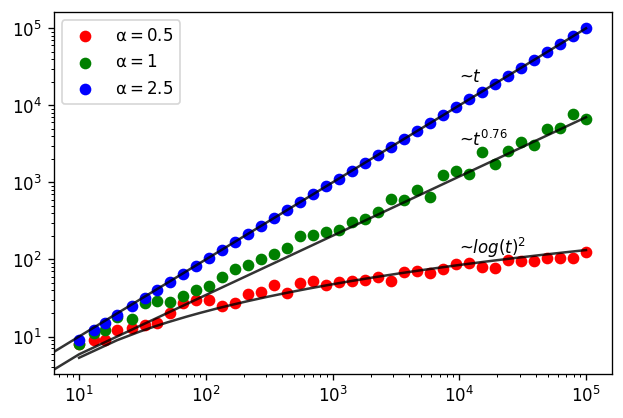

In [257]:
plt.figure(dpi=120)
plt.scatter(allT, result[0], c=colors[0], label="$⍺ = 0.5$")
plt.scatter(allT, result[1], c=colors[1], label="$⍺ = 1$")
plt.scatter(allT, result[2], c=colors[2], label="$⍺ = 2.5$")

x = np.linspace(0, 100000, num=10000)
plt.plot(x, x, c=(0,0,0,0.8))
plt.plot(x, x**(1/1.3), c=(0,0,0,0.8))
plt.plot(x, np.log(x)**2, c=(0,0,0,0.8))

plt.annotate("~$t$", [1e4, 0.2e5])
plt.annotate("~$t^{0.76}$", [1e4, 0.3e4])
plt.annotate("~$log(t)^{2}$", [1e4, 1.2e2])

plt.xscale("log")
plt.yscale("log")
plt.legend()

In [258]:

results = {
    "generator": [],
    "numNodes": [],
    "avgDeg": [],
    "2moment": [],
    "avgShortestPath": [],
    "avgClusterCoeff": [],
    "transitivity": [],
    "assortativity": []
}

def addResult(G, generator):
    results["generator"].append(generator)
    results["numNodes"].append(len(G.nodes))
    
    degs = np.array(getVals(G.degree))
    histX = np.arange(0, np.max(degs) + 1)
    histY = [ np.sum(degs == i) for i in histX ]
    histY = histY / np.sum(histY) # normalize
    moment1 = np.sum([ x*p      for x, p in zip(histX, histY) ])
    moment2 = np.sum([ (x**2)*p for x, p in zip(histX, histY) ])
    results["avgDeg"].append(moment1)
    results["2moment"].append(moment2)
    
    component = max(nx.components.connected_component_subgraphs(G), key=len)
    results["avgShortestPath"].append(nx.average_shortest_path_length(component))
    
    results["avgClusterCoeff"].append(nx.average_clustering(G))
    results["transitivity"].append(nx.transitivity(G))
    results["assortativity"].append(nx.assortativity.degree_assortativity_coefficient(G))

for N in [100, 300, 1000]:
    for i in range(30):
        print("{}-{}".format(N, i), end=" ")

        for alpha in [0.5, 1, 1.5, 2.5]:
            G = graph(N, 3, alpha)
            addResult(G, "nonlinear-{}".format(alpha))

df = pd.DataFrame(results)

100-0 100-1 100-2 100-3 100-4 100-5 100-6 100-7 100-8 100-9 100-10 100-11 100-12 100-13 100-14 100-15 100-16 100-17 100-18 100-19 100-20 100-21 100-22 100-23 100-24 100-25 100-26 100-27 100-28 100-29 300-0 300-1 300-2 300-3 300-4 300-5 300-6 300-7 300-8 300-9 300-10 300-11 300-12 300-13 300-14 300-15 300-16 300-17 300-18 300-19 300-20 300-21 300-22 300-23 300-24 300-25 300-26 300-27 300-28 300-29 1000-0 1000-1 1000-2 1000-3 1000-4 1000-5 1000-6 1000-7 1000-8 1000-9 1000-10 1000-11 1000-12 1000-13 1000-14 1000-15 1000-16 1000-17 1000-18 1000-19 1000-20 1000-21 1000-22 1000-23 1000-24 1000-25 1000-26 1000-27 1000-28 1000-29 

In [261]:
groups = df.groupby(by=["generator", "numNodes"])
groups.mean()

avgDeg      2moment  avgShortestPath  avgClusterCoeff  \
generator     numNodes                                                          
nonlinear-0.5 100        5.880    54.555333         2.628653         0.137751   
              300        5.960    60.190889         3.149446         0.052767   
              1000       5.988    62.732667         3.702687         0.016999   
nonlinear-1   100        5.880    89.551333         2.341017         0.358230   
              300        5.960   147.653556         2.631768         0.255020   
              1000       5.988   243.248200         2.932280         0.155388   
nonlinear-1.5 100        5.880   212.824667         1.955731         0.831937   
              300        5.960   652.199778         1.994815         0.892780   
              1000       5.988  2375.245200         1.999169         0.929802   
nonlinear-2.5 100        5.880   294.647333         1.940606         0.965815   
              300        5.960   891.545778         1.980067         0.987838   
              1000       5.988  2988.154200         1.994006         0.996356   

                        transitivity  assortativity  
generator     numNodes                               
nonlinear-0.5 100           0.107880      -0.096195  
              300           0.046388      -0.023143  
              1000          0.017590       0.024688  
nonlinear-1   100           0.113243      -0.331749  
              300           0.049210      -0.279589  
              1000          0.018781      -0.218884  
nonlinear-1.5 100           0.078781      -0.711460  
              300           0.026548      -0.782886  
              1000          0.007349      -0.836704  
nonlinear-2.5 100           0.060734      -0.954300  
              300           0.020149      -0.981506  
              1000          0.006020      -0.993214

### The most noticeable aspect is that higher values of the alpha parameter leads to more disassortativity; of course, this is because higher alpha leads to bigger hubs being formed. Also, the average shortest path is lower when alpha is high, which is also due to bigger hubs: the big hub becomes a shortcut from every node to every other node.

### We notice an increase in the average cluster coefficient, and a decrement of transitivity, which was uncalled for. The lower transitivity means less triangles are being formed. Why is the clustering high? Let us check

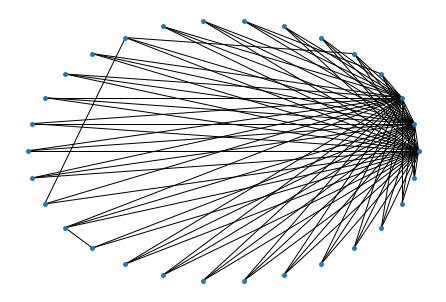

In [269]:
G = graph(30, 3, 2.5)
nx.draw_shell(G, with_labels=False, node_size=15)

### Ok, I got it. The clustering is high because most nodes have only 2 or 3 hubs as neighbors, and these hubs are connected to each other, making triangles. Thus the clustering is high. On the other hand, the transitivity is low because it also considers the triangles that could have been formed among the non-hub nodes.

# Problem 5